<a href="https://colab.research.google.com/github/sbhujel07/Gpt-2_From_Scratch/blob/main/Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# New section

Causal attnention

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F


In [ ]:
inputs=torch.tensor(
    [
   [0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55] # step     (x^6)
    ]
)

In [ ]:
batch=torch.stack((inputs,inputs),dim=0)
print(batch.shape)



torch.Size([2, 6, 3])


In [ ]:
class Causalattnention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,qkv_bias=False):
    super().__init__()
    self.d_out=d_out
    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key= nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value= nn.Linear(d_in,d_out,bias=qkv_bias)
    self.dropout= nn.Dropout(dropout)
    self.register_buffer("mask",torch.triu(torch.ones(context_length,context_length),diagonal=1))


  def forward(self,x):
    b,num_tokens,d_in=x.shape
    keys= self.W_key(x)
    queries=self.W_query(x)
    values=self.W_value(x)
    attnn_scores=queries @ keys.transpose(1,2)
    attnn_scores.masked_fill(
     self.mask.bool()[:num_tokens,:num_tokens],-torch.inf)
    attnn_weights=torch.softmax(
     attnn_scores/keys.shape[-1]**0.5,dim=-1
     )
    attnn_weights=self.dropout(attnn_weights)

    context_vec=attnn_weights @ values
    return context_vec


In [ ]:
torch.manual_seed(123)
context_length=batch.shape[1]
d_in = batch.shape[2]  # input embedding dimension = 3
d_out = 4              # output embedding dimension = 4
ca= Causalattnention(d_in, d_out,context_length,0.0)
context_vec=ca(batch)# same as ca.forward(batch)
print("context_vecs.shape:",context_vec.shape)

print(context_vec)

context_vecs.shape: torch.Size([2, 6, 4])
tensor([[[-0.1450,  0.1643,  0.5086,  0.3406],
         [-0.1424,  0.1729,  0.5073,  0.3428],
         [-0.1425,  0.1727,  0.5074,  0.3428],
         [-0.1414,  0.1709,  0.5066,  0.3430],
         [-0.1428,  0.1677,  0.5077,  0.3423],
         [-0.1411,  0.1727,  0.5063,  0.3432]],

        [[-0.1450,  0.1643,  0.5086,  0.3406],
         [-0.1424,  0.1729,  0.5073,  0.3428],
         [-0.1425,  0.1727,  0.5074,  0.3428],
         [-0.1414,  0.1709,  0.5066,  0.3430],
         [-0.1428,  0.1677,  0.5077,  0.3423],
         [-0.1411,  0.1727,  0.5063,  0.3432]]], grad_fn=<UnsafeViewBackward0>)


Multi Head attnention- multiple head are concatinated(like multiple causal attnention are combined to form a multi head attnention).There is a single head in other attnention mechanism like self and causal but there are multiple head in multi head attnention to perform specific independent functionality.

In [ ]:
class MultiHeadattnentionWrapper(nn.Module):

  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    super().__init__()

    self.heads=nn.ModuleList(
        [Causalattnention(d_in,d_out,context_length,dropout,qkv_bias) for _ in range(num_heads)]
    )

  def forward(self,x):
    return torch.cat([head(x) for head in self.heads],dim=-1)


In [ ]:
torch.manual_seed(123)
context_length=batch.shape[1]
d_in,d_out=3,2
mha=MultiHeadattnentionWrapper(d_in,d_out,context_length,0.0,num_heads=2)
context_vec=mha(batch)
print(context_vec)
print("context_vec.shape",context_vec.shape)

tensor([[[-0.5337, -0.1051,  0.5085,  0.3508],
         [-0.5323, -0.1080,  0.5084,  0.3508],
         [-0.5323, -0.1079,  0.5084,  0.3506],
         [-0.5297, -0.1076,  0.5074,  0.3471],
         [-0.5311, -0.1066,  0.5076,  0.3446],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.5337, -0.1051,  0.5085,  0.3508],
         [-0.5323, -0.1080,  0.5084,  0.3508],
         [-0.5323, -0.1079,  0.5084,  0.3506],
         [-0.5297, -0.1076,  0.5074,  0.3471],
         [-0.5311, -0.1066,  0.5076,  0.3446],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vec.shape torch.Size([2, 6, 4])


**MultiHead attnention By Splits the Weight**

Instead of maintaining two separate classes, MultiHeadattnentionWrapper and
Causalattnention, we can combine both of these concepts into a single
MultiHeadattnention class.

Also, in addition to just merging the
MultiHeadattnentionWrapper with the Causalattnention code, we will make some other
modifications to implement multi-head attnention more efficiently.
</div>

In [ ]:
class MultiHeadattnention(nn.Module):
  def __init__(self,d_in,d_out,context_length,dropout,num_heads,qkv_bias=False):
    super().__init__()

    assert d_out % num_heads==0  #"d_out must be divisible by num_heads"


    self.d_out=d_out
    self.num_heads=num_heads
    self.head_dim=d_out//num_heads

    self.W_query=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_key=nn.Linear(d_in,d_out,bias=qkv_bias)
    self.W_value=nn.Linear(d_in,d_out,bias=qkv_bias)

    self.out_proj=nn.Linear(d_out,d_out)
    self.dropout=nn.Dropout(dropout)

    self.register_buffer(
        "mask",torch.triu(torch.ones(context_length,context_length),diagonal=1)
    )


  def forward(self,x):
    b,num_tokens,d_in=x.shape

    keys=self.W_key(x) #Shape:(b,num_tokens,d_out)
    queries=self.W_query(x)
    values=self.W_value(x)


    # We implicitly split the matrix by adding a `num_heads` dimension
    # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
    keys=keys.view(b,num_tokens,self.num_heads,self.head_dim)
    queries=queries.view(b,num_tokens,self.num_heads,self.head_dim)
    values=values.view(b,num_tokens,self.num_heads,self.head_dim)

    #Transpose:(b,num_tokens,num_heads,head_dim)=> (b,num_heads,num_tokens,head_dim)
    keys=keys.transpose(1,2)
    queries=queries.transpose(1,2)
    values=values.transpose(1,2)


    attnn_scores= queries @ keys.transpose(2,3)  #Dot product for each head

    # Original mask truncated to the number of tokens and converted to boolean
    mask_bool=self.mask.bool()[:num_tokens,:num_tokens]

    attnn_scores.masked_fill(mask_bool,-torch.inf)

    attnn_weights=torch.softmax(attnn_scores/keys.shape[-1]**0.5,dim=-1)
    attnn_weights=self.dropout(attnn_weights)

    #shape: (b,num_tokens,num_heads,head_dim)
    context_vec = (attnn_weights @ values).transpose(1,2)  #context vexctor calculate garney ani original shapes ma transform garney

    # Combine heads, where self.d_out = self.num_heads * self.head_dim
    context_vec= context_vec.contiguous().view(b,num_tokens,self.d_out)
    context_vec= self.out_proj(context_vec) #optional Projection


    return context_vec







<div class="alert alert-block alert-info">

Step 1: Reduce the projection dim to match desired output dim

Step 2: Use a Linear layer to combine head outputs

Step 3: Tensor shape: (b, num_tokens, d_out)

Step 4: We implicitly split the matrix by adding a `num_heads` dimension. Then we unroll last dim: (b,
num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

Step 6: Compute dot product for each head

Step 7: Mask truncated to the number of tokens

Step 8: Use the mask to fill attnention scores

Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

Step 11: Add an optional linear projection
**bold text**

**INFERENCE** **TEST**

In [ ]:

inputs=torch.tensor(
    [
   [0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55] # step     (x^6)
    ]
)
batch=torch.stack((inputs,inputs),dim=0)


torch.manual_seed(123)
batch_size,context_length,d_in=batch.shape
d_out =2
mha= MultiHeadattnention(d_in,d_out,context_length,0.0,num_heads=2)
context_value=mha(batch)
print(context_value)


tensor([[[0.2595, 0.4014],
         [0.2583, 0.4014],
         [0.2583, 0.4014],
         [0.2575, 0.4031],
         [0.2582, 0.4026],
         [0.2575, 0.4028]],

        [[0.2595, 0.4014],
         [0.2583, 0.4014],
         [0.2583, 0.4014],
         [0.2575, 0.4031],
         [0.2582, 0.4026],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)


**BIRDS EYES VIEW OF LLM** <br> -See in Youtube Videos Of Vizuara

# **1.Layer Normalization**  <br> -For the theory part of layer normalization see youtube and jupyter notebook of Vizuara

In [ ]:
from typing import Self
class LayerNormalization(nn.Module):
  def __init__(self,emd_dim) :
   super().__init__()
   self.eps=1e-5
   self.scale=nn.Parameter(torch.ones(emd_dim))   #nn.parameter refers to the trainable  parameters that change or adjust the weight during training to reduce the loss
   self.shift=nn.Parameter(torch.zeros(emd_dim))


  def forward(self,x):
   mean=x.mean(dim=-1,keepdim=True)
   variance=x.var(dim=-1,keepdim=True,unbiased=False)
   norm_x=(x-mean)/torch.sqrt(variance+self.eps)
   return self.scale*norm_x + self.shift


#Normalized garesi normalized tensor ko mean calculate garda 0 and variance calculate garda 1 hunuparxa
#normalized  = (x-mean/square root inside the variance)
#kina layer normalized because Normalizing each token’s features keeps the values in a stable range — gradients don’t blow up or vanish.

# Inference Testing of Layer Normalized

In [ ]:
torch.manual_seed(123)
batch_example= torch.randn(2,5)  #2 ta batch and input has
layer=nn.Sequential(nn.Linear(5,6),nn.ReLU())
out = layer(batch_example)
print(out)


tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Lets now try the LayerNormal module in practice and apply it to the batch input

In [ ]:
ln= LayerNormalization(5)
torch.set_printoptions(sci_mode=False)
out_ln=ln(batch_example)
mean= out_ln.mean(dim=-1,keepdim=True)
variance = out_ln.var(dim=-1,keepdim=True)
print("Mean:",mean)
print("variance:",variance)

Mean: tensor([[-0.0000],
        [ 0.0000]], grad_fn=<MeanBackward1>)
variance: tensor([[1.2499],
        [1.2500]], grad_fn=<VarBackward0>)


# **2.The GELU Activation and FeedForward Network**

GELU Activation:<br>-PyTorch uses an approximate form:  
     GELU(x) = 0.5 * x * (1 + torch.tanh(√(2/π) * (x + 0.044715 * x³)))<br>-GELU lets small negative or near-zero values pass slightly, instead of completely blocking them (like ReLU does).
That makes it smoother and better for gradient flow, improving training stability. *italicised text*


# Let's implement the GELU activation function approximation used by GPT-2:

In [ ]:
class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

Next, let's use the GELU function to implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:

In FeedForward Layer there is 3 layes <br>
-Linear Layer(Expansion)- Embedding dimension Expansion by 4  <br>
-GELU Activation <br>
-Linear Layer(Contraction)- Embedding Dimension Contraction by 4 and the dimesion is preserved i.e will be same dimesion

In [ ]:
GPT_CONFIG_124M = {         ##GPT2 ley use gareko architecture use gareko hamro model train garna
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attnention heads
    "n_layers": 12,         # Number of layers / number of transformer
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, cfg) :
    super().__init__()
    self.layers=nn.Sequential(                      ##nn.Sequential ley k garxa vani sequentially kaam garxa like first ma input layer1 ma pass hunxa ani tei input expamsio vayera gelu and then last layer ma pugxa
        nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]),  #expansion hunxa yesma like dimension *4 ley expansion hunxa
        GELU(), #ani expansion vako neural Gelu function use hunxa
        nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]) #last layer ma aayera tei input size ma convert hunxa
    )

  def forward(self,x):
      return self.layers(x)

In [ ]:
print(GPT_CONFIG_124M["emb_dim"])

768


Let's use the GELU function to implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:

In [ ]:
ff=FeedForward(GPT_CONFIG_124M)
x=torch.rand(2,3,768)
out=ff(x)
print(out.shape)
print(out)

torch.Size([2, 3, 768])
tensor([[[ 0.1238,  0.0457,  0.0939,  ...,  0.1107,  0.0167, -0.1992],
         [ 0.1574, -0.0282,  0.0049,  ...,  0.0026,  0.1120, -0.1075],
         [ 0.1184, -0.0052,  0.0839,  ...,  0.1662,  0.0112, -0.1685]],

        [[ 0.1302,  0.0630,  0.1050,  ...,  0.1439,  0.0562, -0.1128],
         [ 0.1249, -0.0073,  0.1022,  ...,  0.0417,  0.0381, -0.0828],
         [ 0.0494,  0.0654,  0.0347,  ...,  0.0701,  0.0793, -0.1810]]],
       grad_fn=<ViewBackward0>)


# **3.ShortCut Connection**

-Neural network ma ek layer ko output sidhai arko layer ma jodne system ho,jasko bich ma dherai layers (processing steps) skip garincha.
Tesaile yeslai skip connection pani bhanincha.

-Without Skip connection <br>
Input → Layer1 → Layer2 → Layer3 → Output <br><br>

-With S.C<br>
Input → Layer1 → Layer2 → Layer3 → Output+Input <br><br>

Mathematical Intution:
xl+1​=xl​+f(xl​)   => output+input of previous layer<br>

and in During backpropagation:
∂xl​∂L​=∂xl+1​∂L​⋅(1+∂xl​∂f(xl​)​) <br> <br> <br>


Why ShortCut Connection?<br>
Because gradient lai vanish huna dinna backpropagation ko belama ani like every gradient calculate garda +1 hunxa through loss.Yesley garda model training ramro hunxa.

In [ ]:
#Coding of Shortcut Connection Without Shortcut Connection and with shortcut connection

class ExampleOfDeepLearning(nn.Module):
  def __init__(self,layer_sizes,use_shortcut):
    super().__init__()
    self.use_shortcut=use_shortcut
    layers=nn.ModuleList([
        nn.Linear(layer_sizes[0],layer_sizes[1],GELU()),
        nn.Linear(layer_sizes[1],layer_sizes[2],GELU()),
        nn.Linear(layer_sizes[2],layer_sizes[3],GELU()),
        nn.Linear(layer_sizes[3],layer_sizes[4],GELU()),
        nn.Linear(layer_sizes[4],layer_sizes[5],GELU())
    ])

  def forward(self,x):
    for layer in self.layers:
      #compute the output of current layer
      layerOutput=layer(x)

      #check if shotcut can be applied
      if self.use_shortcut and x.shape == layerOutput.shape:
        x = x+layerOutput

      else:
        x=layerOutput

    return x

lets initialize the neural network without the shorcut connection

In [ ]:
layer_sizes=[3,3,3,3,3,1] #this means that 5 input layer of 3 neurons and 1 output layer of neural newtork
sample_input=torch.tensor([[1.,0.,-1.]])  #this [[]] means that the 1 batch with the 3 token
torch.manual_seed(123)
model_without_shortcut=ExampleOfDeepLearning(
    layer_sizes,use_shortcut=True
)

Lets create a gradient function that compute the gradient in backward pass:

In [ ]:
def print_gradient(model,x):
  #forward pass
  output=model(x)
  target=torch.tensor([[0.]])

  #calculate the loss based on how close was
  #and ouput are
  loss=nn.MSELoss()
  loss=(output,target)

  #backward pass to calculate the gradient
  loss.backward()

  for name,param in model.named_parameters():
    if "weight" in name:
      #print the mean absoulte gradient of the weights
      print(f"{name} has gradient mean of {param.grad.abs().mean.item()}")



In [ ]:
print_gradient(model_without_shortcut,sample_input)

AttributeError: 'ExampleOfDeepLearning' object has no attribute 'layers'

# BUILDING THE GPT ARCHITECTURE AND CODE <br> <br>

**The Building Blocks of Layer Normalization,Gelu And feed-Forward Neural Network and Transformer Block**

1.TOKENIZATION

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
batch = []
txt1 = "Every effort moves you"
txt2 = "Every day holds a"
batch.append(torch.tensor(tokenizer.encode(txt1)))
batch.append(torch.tensor(tokenizer.encode(txt2)))
batch = torch.stack(batch, dim=0)
print(batch)

**2.Define the Layer Normalization **

In [ ]:
class LayerNormalization(nn.Module):
  def __init__(self,emb_dim):
    super().__init__()
    self.eps=1e-5
    self.scale=nn.Parameter(torch.ones(emb_dim))
    self.shift=nn.Parameter(torch.zeros(emb_dim))

  def forward(self,x):
    mean=x.mean(dim=-1,keepdim=True)
    variance=x.var(dim=-1,keepdim=True)
    normalize=(x-mean)/torch.sqrt(variance+self.eps)
    return self.scale*normalize+self.shift


class GELU(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,x):
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.layers=nn.Sequential(
          nn.Linear(cfg["emb_dim"],4*cfg["emb_dim"]), #Expansion
          GELU(),
          nn.Linear(4*cfg["emb_dim"],cfg["emb_dim"]) #Contraction
    )


  def forward(self,x):
      return self.layers(x)



# 3.Now Lets code a transformer block as follows:

step 1:Shortcut Connection for attnention block<br>
step 2:Shortcut Connection for feed forward block<br>
step 3:Add the original input back


In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.attnn=MultiHeadattnention(
        d_in=cfg["emb_dim"],
        d_out=cfg["emb_dim"],
        context_length=cfg["context_length"],
        num_heads=cfg["n_heads"],
        dropout=cfg["drop_rate"],
        qkv_bias=cfg["qkv_bias"]
    )
    self.ff=FeedForward(cfg)
    self.norm1=LayerNormalization(cfg["emb_dim"])
    self.norm2=LayerNormalization(cfg["emb_dim"])
    self.drop_shortcut=nn.Dropout(cfg["drop_rate"])

  def forward(self,x):
    #Shortcut connection for attnention block
    shortcut=x
    x=self.norm1(x)
    x=self.attnn(x)
    x=x+shortcut

    #shortcut connection for feedforward block
    shortcut=x
    x=self.norm2(x)
    x=self.ff(x)
    x=self.drop_shortcut(x)
    x=x+shortcut

    return x




# GPT Architecture -Entire GPT2 Architecture Implementation

In [ ]:
GPT_CONFIG_124M = {         ##GPT2 ley use gareko architecture use gareko hamro model train garna
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attnention heads
    "n_layers": 12,         # Number of layers / number of transformer
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
#We started with the dummy GPT model class



class DummyGPTModel(nn.Module):
  def __init__(self,cfg):
    super().__init__()
    self.token_emb=nn.Embedding(cfg["vocab_size"],cfg["emb_dim"])  #yesma chai token id vector embedding hunxa like each token vector ma convert hunxa
    self.position_emb=nn.Embedding(cfg["context_length"],cfg["emb_dim"])  #yesma each token lai position id dinxa and maximum input token 1058 samma dina milxa
    self.drop_emb=nn.Dropout(cfg["drop_rate"])

    self.transformer_block=nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])]
        ) # "*" is used because pytorch ko nn.swquential ley [] vitra ko lai yeuta layer samjhinxa so * ley different layer hunxa

    self.final_norms=LayerNormalization(cfg["emb_dim"])
    self.out_head=nn.Linear(
        cfg["emb_dim"],cfg["vocab_size"],bias=False
    )



  def forward(self,in_idx):
    batch_size,seq_len=in_idx.shape # in_idx yo chai tokenizer text ho and batch ra sequence length ma xuttinxa yo code ley (.shape is essential because yo batch ra seqlength ma xuttauda tei size hosh vanera)
    token_embeds=self.token_emb(in_idx)
    position_embeds=self.position_emb(torch.arange(seq_len,device=in_idx.device))
    x=token_embeds+position_embeds
    x=self.drop_emb(x)
    x=self.transformer_block(x)
    logits=self.out_head(x)

    return logits




Lets initialize the GPT model

In [ ]:
torch.manual_seed(123)
model = DummyGPTModel(GPT_CONFIG_124M)
out = model(batch)
print(batch)
print("Output Shape",out.shape)
print("Output is:",out)

# STEP TO PREDICT THE NEXT TOKEN <br>
# Step 1: Extract the last vector from the output tensor<br>
# step 2:Convert Logits into probabilities by appling softmax<br>
# step 3:Identify the index position(token id) with the largest value<br>
# step 4:Apppend token id to the previous input for the next token round.

In [ ]:
def generate_text_simple(model,idx,max_new_tokens,context_size):
  for _ in range(max_new_tokens):
    idx_cond=idx[:,-context_size:] ##row sabai ligney and end bata context_size samma ligney e.g context length is 5 and my text is "hi hello how are you feeling" then idx_cond=last bata 5 ota text i.e hello how are you feeling

    #Get the prediction
    with torch.no_grad():  #it means no gradient
      logits = model(idx_cond)

    #take the last tensor from the logits
    logits=logits[:,-1,:]   # logits ko shape [batch,n_token,vocab_size] so second dimension ko last ko element ligney kina vaney model ko logits ma last element hamley predict garnuparney xa

    #Apply the softmax and get probabilities
    normalize=torch.softmax(logits,dim=-1)

    #get the index of probability having the greatest value
    idx_next=torch.argmax(normalize,dim=-1,keepdim=True)   #(batch,1)

    #append sample index to running sequence
    idx=torch.cat((idx,idx_next),dim=1)


  return idx



In [ ]:
model.eval()
out=generate_text_simple(
    model=model,idx=batch,max_token=6,context_size=GPT_CONFIG_124M["context_length"]
)
print("Output:",out)
print(out.shape)

NameError: name 'batch' is not defined

In [ ]:
#Decode the Text (tensor to text)
decode_text=tokenizer.decode(out[0].tolist())
print(decode_text)

decode_text = tokenizer.decode(out[1].tolist())
print(decode_text)


NameError: name 'out' is not defined

# Now we havenot train our model so that the output is not meaningful as we expexted.Thats why we need to train our model so we use LLM loss function i.e Cross Entropy Loss.Everytime we calculate the output(logits) then everytime check to the true training value and calculate the entropy loss until the model predict wright output.

**-We go backpropagation and update the weight until loss entropy is up to zero.Since the loss function is about zero then the model output is acccurat**e

**-Lets define the function ecode and decode.Ecode function convert the input text to vectors(token id) and Decode function convert the vector back to output text.By Using TikToken of OpenAi.**

In [ ]:
import tiktoken

def text_to_tokenId(text,tokenizer):
  encoded = tokenizer.encode(text,allowed_special={'<endoftext>'})
  encoded_tensor = torch.tensor(encoded).unsqueeze(0)  #add the batch dimension
  return encoded_tensor

def tokenId_to_text(tokenId,tokenizer):
  flat=tokenId.squeeze(0)  #remove batch dimension
  return tokenizer.decode(flat.tolist())


In [ ]:
tokenizer=tiktoken.get_encoding("gpt2")

In [ ]:
text="Every effort moves you"
tokenizer=tiktoken.get_encoding("gpt2")

token_id=generate_text_simple(
    model=model,
    idx=text_to_tokenId(text,tokenizer),
    max_token=10,
    context_size=GPT_CONFIG_124M["context_length"])
print("Output:\n",tokenId_to_text(token_id,tokenizer))






NameError: name 'generate_text_simple' is not defined

**CROSS ENTROPHY LOSS** <br>
**-measure the loss between two probability distribution**

**flow of this loss: <br>**
logits => probabilities => Target Probabulities => Log Probabilities => Average Log Probabilities =>Negative average log probabilities

**now, first we will see without using the cross entrophy loss **

In [ ]:
#let us take a input and the target tensors


inputs=torch.tensor([[1688,3626,6100],   #Every effort makes
                     [40,1107,588]])     #I really like

target=torch.tensor([[3626,6100,345],    #Every effort makes you
                     [1107,588,11311]])  #I really like chocolate



#Applying the softmax function, we can turn the logits tensor into a tensor of the same dimension containing probability scores

with torch.no_grad():
    logits = model(inputs)   # output of the model

probas = torch.softmax(logits, dim=-1) # Probability of each token in vocabulary
print(probas.shape) # Shape: (batch_size, num_tokens, vocab_size)



text_idx=0
target_probas_1=probas[text_idx,[0,1,2],target[text_idx]]    #"Batch 0 को sequences positions 0,1,2 मा model ले सही target शब्दलाई कति probability दियो?" .It gives you the probability of the correct word at each timestep.
#target ko index herera probability nikalxa ani tyo probalility loss function calculate gardai 1 samma purainxa
print("text1",target_probas_1)

text_idx=1
target_probas_2=probas[text_idx,[0,1,2],target[text_idx]]

print("text2",target_probas_2)



In [ ]:
#compute the logarithm of all token probabilities
log_probas=torch.log(torch.cat((target_probas_1,target_probas_2)))  #first catinate two probas and use log
print(log_probas)

In [ ]:
#Calculate the average probability for each token
mean_probas=torch.mean(log_probas)
print(mean_probas)

In [ ]:
#now taking the taking the negative to minizing the loss.Our goal is to make the probality of each token to 1 so that the corresponding tensor is eqaul to the target tensor and model can predict accurate.
neg_avg_log_probas=mean_probas * -1
print(neg_avg_log_probas)

**We learnt about the loss entropy manually in above code.Now we use pytorch module**

In [ ]:
#first we need to flattnen the logits and make the one batch
logits_flattnen=logits.flattnen(0,1)
target_flattnen=target.flattnen()
print("logit:",logits_flattnen.shape)
print("target:",target_flattnen.shape)

In [ ]:
#calculate loss
loss=torch.nn.functional.cross_entropy(logits_flattnen,target_flattnen)
print(loss)

## Calculate the Training and Validation Losses for the book data scrab from the internet

In [ ]:
GPT_CONFIG_124M = {         ##GPT2 ley use gareko architecture use gareko hamro model train garna
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attnention heads
    "n_layers": 12,         # Number of layers / number of transformer
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
#this block is not used because when the data is scrab from github it only provides the html page so we use the another method in next code block.
import os
import urllib.request

file_path="the-verdict.txt"
url="https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"


if not os.path.exists(file_path):
  with urllib.request.urlopen(url) as response:
    text_data=response.read().decode('utf-8')

  with open(file_path,"w",encoding="utf-8") as file:
    file.write(text_data)

else:
  with open(file_path,"r",encoding="utf-8") as file:
    text_data=file.read()

In [ ]:
print(text_data[:99])

In [ ]:
#Mathi ko code ley html matra output diyo so hamle github ko api use garera data tanem.(collab use garera html matra output but hamle vs code use gareko vaye chai text output nai dinthyo same code ley)

import urllib.request
import json
import base64

api_url = "https://api.github.com/repos/rasbt/LLMs-from-scratch/contents/ch02/01_main-chapter-code/the-verdict.txt"

req = urllib.request.Request(api_url, headers={"User-Agent": "Mozilla/5.0"})

with urllib.request.urlopen(req) as response:
    data = json.loads(response.read().decode())
    text_data = base64.b64decode(data["content"]).decode("utf-8")

print(text_data[:200])

print(text_data[-99:])


I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no great surprise to me to hear that, in the height of his glory, he had dropped his painting, married a
it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")
total_character=len(text_data)
total_token=len(tokenizer.encode(text_data))
print("Total character is:",total_character)
print("Total token in the book is:",total_token)


Total character is: 20479
Total token in the book is: 5145


# Implementing the Data loader

In [ ]:

from torch.utils.data import Dataset,DataLoader


class GptDatasetV1(Dataset):
  def __init__(self,txt,tokenizer,max_length,stride):
    self.input_ids=[]
    self.target_ids=[]

    #tokenize the entire text
    token_ids=tokenizer.encode(txt,allowed_special={"<|endoftext|>"})

    #Use a sliding window to chunk the book into overlaping sequence of max_length
    for i in range(0,len(token_ids)-max_length,stride):  #range(start, stop, step) stride vaneko chai one iterate ma kati ota token pathauney
      input_chunk=token_ids[i:i+max_length]
      target_chunk=token_ids[i+1:i+max_length+1]
      self.input_ids.append(torch.tensor(input_chunk))
      self.target_ids.append(torch.tensor(target_chunk))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self,idx):
    return self.input_ids[idx],self.target_ids[idx]

def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128,shuffle=True,drop_last=True,num_workers=0):
  #initialize the tokenizer
  tokenizer=tiktoken.get_encoding("gpt2")

  #create dataset
  dataset=GptDatasetV1(txt,tokenizer,max_length,stride)  #dataset ma input id and target Id  basxa


  #create dataloader (from dataset and dataloader documentation of pytorch)- Dataloader ko through bata dataset(iput_id+target_id lai batch garxa)
  dataloader=DataLoader(
      dataset,
      batch_size=batch_size,
      shuffle=shuffle,
      drop_last=drop_last,
      num_workers=num_workers
  )


  return dataloader

In [ ]:
#Train/Validation ratio
train_ratio=0.90
split_idx=int(train_ratio * len(text_data))
train_data=text_data[:split_idx]
val_data=text_data[split_idx:]

torch.manual_seed(123)
train_loader=create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0

)

val_loader=create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)




In [ ]:
print(train_loader)
print(len(train_loader.dataset))


18


In [ ]:
#Sanity check

if total_token * train_ratio < GPT_CONFIG_124M["context_length"]:
    print("Not enough tokens for the training loader. "
          "Try to lower the 'GPT_124M[\"context_length\"]' or "
          "increase the 'training ratio'.")
if total_token*(1-train_ratio)<GPT_CONFIG_124M["context_length"]:
  print("Not enough tokens for the training loader. "
          "Try to lower the 'GPT_124M[\"context_length\"]' or "
          "increase the 'training ratio'.")


In [ ]:
print("Train Loader")
for x,y in train_loader:
  print(x.shape,y.shape)


print("\nValidation loader:")
for x,y in val_loader:
  print(x.shape,y.shape)

print(len(train_loader))
print(len(val_loader))

Train Loader
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])
9
1


In [ ]:
#check if the data loaded correctly
train_tokens=0
for input_batch,target_batch in train_loader:
  train_tokens += input_batch.numel()
  ## .numel() is a PyTorch tensor method that tells you the total number of elements in the tensor, i.e., it flattnens the tensor in your mind and counts every value.

val_tokens=0
for input_batch,target_batch in val_loader:
  val_tokens += input_batch.numel()

print("Training tokens:",train_tokens)
print("validation tokens:",val_tokens)
print("All tokens:",train_tokens+val_tokens)

Training tokens: 4608
validation tokens: 512
All tokens: 5120


# Here is the GPT model class we coded earlier.We will need this



In [ ]:
torch.manual_seed(123)
model=model = DummyGPTModel(GPT_CONFIG_124M)
model.eval(); #Disable dropout during inference

**Now We fetch the data into gpt model and we need to calculate the coss-entropy loss of a given batch.**

In [ ]:
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch,target_batch=input_batch.to(device),target_batch.to(device)
  #.to(device) in PyTorch moves a tensor to the specified device, either CPU or GPU.
  logits=model(input_batch)
  loss=torch.nn.functional.cross_entropy(logits.flattnen(0,1),target_batch.flattnen())
  return loss


def calc_loss_loader(data_loader,model,device,num_batches=None):
  total_loss=0
  if len(data_loader)==0:
    return float("nan")

  elif num_batches is None:
    num_batches=len(data_loader)

  else:
    #reduce the number of batches to match the total number of batches in the data loader
    #if num_batches exceeds the number of batches in the data loader
    num_batches=min(num_batches,len(data_loader))


  for i,(input_batch,target_batch) in enumerate(data_loader):
    if i<num_batches:
      loss=calc_loss_batch(input_batch,target_batch,model,device)
      total_loss += loss.item()

    else:
      break

  return total_loss/num_batches





In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.manual_seed(123)
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device)
  val_loss=calc_loss_loader(val_loader,model,device)


print("Training loss:",train_loss)
print("Validation loss:",val_loss)

Training loss: 11.282607608371311
Validation loss: 11.249894142150879


# LLM Pretraining LOOP <br>
# -We have to train(backpropagate the model so that the model can learn)

# STEPS FOR PRETRAINING DATA
-step 1: for each training epoch<br>
-stpe 2: for each batch in training set <br>
-step 3: reset loss gradient from previous epoch<br>
-step 4: calculate loss on current batch<br>
-stpe 5: backward pass to calculate loss gradient<br>
-step 6: Update model using loss gradients<br>
-step 7: Print training and validation set losses<br>
-step 8: generate sample text



In [ ]:
def evaluate_model(model,train_loader,val_loader,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss=calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
    val_loss=calc_loss_loader(val_loader,model,device,num_batches=eval_iter)

  model.train()
  return train_loss,val_loss


In [ ]:
def generate_and_print_sample(model,tokenizer,device,start_context):
  model.eval()
  context_size=model.position_emb.weight.shape[0]
  encoded=text_to_tokenId(start_context,tokenizer)
  with torch.no_grad():
    token_ids=generate_text(model=model,     #at first we use generate_simple_text func then model has overfitting problem,so we use decoding technique at bottom using topk sampling and temperature scalling and also use multinomial func instaed of argmax then we use generate_text func
                                   idx=encoded,
                                   max_new_tokens=50,
                                   context_size=context_size,
                                   top_k=25,
                                   temperature=1.4,
                                    )

    decoded_text=tokenId_to_text(token_ids,tokenizer)
    print(decoded_text.replace("\n","")) #compact print format
    model.train()

In [ ]:
#now train the model

def train_model(model,train_loader,val_loader,optimizer,device,num_epochs,eval_freq,eval_iter,start_context,tokenizer):
  #initialize lists to track losses and token seen
  train_losses,val_losses,track_tokens_seen=[],[],[]
  tokens_seen,global_step=0,-1

  #main training loop
  for epoch in range(num_epochs):
    model.train() #set model to training mode

    for input_batch,target_batch in train_loader:
      optimizer.zero_grad() #It clears (resets) all the gradients of your model parameters to zero
      loss=calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward() #calculate loss gradient
      optimizer.step() #update model weights using loss gradients
      tokens_seen += input_batch.numel()
      global_step += 1

      #optimal evaluation step: printing training and validation set loss after certain batch and epochs
      if global_step % eval_freq==0:  #it means that after only e.g 5 batches we show this losses like after certain number of batches then only we will show this losses
        train_loss,val_loss=evaluate_model(model,train_loader,val_loader,device,eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        track_tokens_seen.append(tokens_seen)
        print(f"Ep{epoch+1}(Step{global_step:06d}):"
              f"Train loss {train_loss:3f},val loss {val_loss:3f}")


        #print a sample text after each epoch
        generate_and_print_sample(
            model,tokenizer,device,start_context
        )

  return train_loss,val_loss,track_tokens_seen



The generate_and_print_sample function is a convenience function that we use to track whether the model improves during the training.

In particular, the generate_and_print_sample function takes a text snippet (start_context) as input, converts it into token IDs, and feeds it to the LLM to generate a text sample using the generate_text_simple function we used earlier

Let's see this all in action by training a GPTModel instance for 10 epochs using an AdamW optimizer and the train_model_simple function we defined earlier.



In [ ]:
import time
start_time=time.time()

torch.manual_seed(123)
model=DummyGPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer=torch.optim.AdamW(model.parameters(),lr=0.0004,weight_decay=0.1)
num_epochs=5
train_losses,val_losses,token_seen=train_model(model,
                              train_loader,val_loader,optimizer,device,num_epochs=num_epochs,eval_freq=5,eval_iter=5,
                              start_context="Every effort moves you",tokenizer=tokenizer)

end_time=time.time()
execution_time_minutes = (end_time-start_time)/60
print(f"Training completed in {execution_time_minutes:.2f}minutes.")

Ep1(Step000000):Train loss 9.381797,val loss 9.899141
Every effort moves you convictions sublime peacefully Wy perpetually continents negotiation Select Garfield Chicago collectsgraduate decentral darkest Poland Variable Generally ENTER explosion realise snapping Humane admin operational typeitationExc51?!" Method primarily inadvertently likewise corrected poles Laians crazywho storesooter silhouDesk founderhub peanutsMyth skull useless tert
Ep1(Step000005):Train loss 7.746682,val loss 9.337255
Every effort moves yougall undergoneamotoUnity penetrating consultantSingle contractors 1989responsive…………illation property rhet030 Authorities�Ter Courtney777ulators bart tripod Started gullgreSQL Dynamo Trem Mysteries VishSTATE plans Bram shootings agonyFan=> Cosby Hasanalloc scholarshipsheitoho Ad Mouse awakening tunnels github warheads Reverse
Ep2(Step000010):Train loss 5.296806,val loss 7.647337
Every effort moves youFigure045 Leadership ArmstrongoSbes Manufactdh Fair emancipation actionsso

# As we saw the output,at first epoch the model only predict the ,,,,, as a output and slowly it starts to predict good at epoch 10.But,the output are not meaningful,the model cannot predict the more natural and meaningful output.It only momorize the text from the books during the training and predict the momorized text.Lokking the loss training loss ranges from 9.38 to 0.14 which is good but validation loss is 9.89 to 9.01 so the model is overfit.This is called Overfitting.Thats why we need to avoid overfiting using two technique(Decoding Strategies To Control Randomness):<br>
# 1.TEMPERATURE SCALING <br>
# 2.TOP-K SAMPLING

# 1.Decoding Strategies To Control Randomness Using TEMPERATUTE SCALING

-Temperature Scaling is used to remove the randomness of the model and to make the prediction better.First we get the logits from the output and use temperature like logits/temperature.For an example, temperature = -1,1,5 then if we use temperature value =-1 only the probalility having highest is constrast and the model only predict this token having highest probabilty.Else if we use temperature=5 then model logits=logits/temp  so the probability of all the samples are greater then random unmeaningul text are generated.But if we use temp=1 then the result would be good.Therefore,temperature value should be average not too high and too low.

A temperature of 1 divides the logits by 1 before passing them to the softmax function to compute the probability scores.

In other words, using a temperature of 1 is the same as not using any temperature scaling.

In this case, the tokens are selected with a probability equal to the original softmax probability scores via the multinomial sampling function in PyTorch.

# STEPS:
# i.Temp_logits = logits/Temperature <br>
# ii.Softmax(Temp_logits) <br>
# iii.Use multinomial function instead of argmax function


Applying very small temperatures, such as 0.1, will result in sharper distributions such that the behavior of the multinomial function selects the most likely token (here: "forward") almost 100% of the time, approaching the behavior of the argmax function.

Vice versa, a temperature of 5 results in a more uniform distribution where other tokens are selected more often.

This can add more variety to the generated texts but also more often results in nonsensical text.

For example, using the temperature of 5 results in texts such as "every effort moves you pizza" about 4% of the time.


# 2.DECODING STRATEGIES TOP-K SAMPLING

STEPS:<br>
i.Logits tensor bata select top highest number of probability (like k=3 i.e top 3 highest probability)<br>
ii.Put infinity in rest of the probability(Except these selected highest probability)<br>
iii.Use Softmax<br>
iv.Use Multinomial function

In [ ]:
#for an Example

next_logits_tensor=torch.tensor(
[4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)



top_k=3

#calculate highest top k
top_logits,top_position=torch.topk(next_logits_tensor,top_k)
print(top_logits)
print(top_position)

tensor([6.7500, 6.2800, 4.5100])
tensor([3, 7, 0])


In [ ]:
new_logits=torch.where(    #torch.where ko documentation ramrari padhnu hola this is tricky
    condition=next_logits_tensor<top_logits[-1],   #indexing -1 ley sadhai last element nikalxa
    input=torch.tensor(float("-inf")),
    other=next_logits_tensor
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [ ]:
topk_probability=torch.softmax(new_logits,dim=-1)
print(topk_probability)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


## MERGE TEMPERATURE SCALING AND Top-k SCALING

We can now apply the temperature scaling and multinomial function for probabilistic sampling introduced in the previous section to select the next token among these 3 nonzero probability scores to generate the next token. We do this in the next section by modifying the text generation function.

The previous two subsections introduced two concepts to increase the diversity of LLMgenerated text: temperature sampling and top-k sampling. In this section, we combine and add these concepts to modify the generate_simple function we used to generate text via the LLM earlier, creating a new generate function:

Step 1: For-loop is the same as before: Get logits, and only focus on last time step

Step 2: In this new section, we filter logits with top_k sampling

Step 3: This is the new section where we apply temperature scaling

Step 4: Carry out greedy next-token selection as before when temperature scaling is disabled

Step 5: Stop generating early if end-of-sequence token is encountered and eos_id is specified

In [ ]:
def generate_text(model,idx,max_new_tokens,context_size,temperature=0.0,top_k=None,eos_id=None):
  for _ in range(max_new_tokens):
    idx_cond=idx[:,-context_size:]
    with torch.no_grad():
      logits=model(idx)
    logits=logits[:,-1,:]  #logits ko last ko element matra ligney


   #apply the topK sampling
    if top_k is not None:
      top_logits,top_position=torch.topk(logits,top_k)
      min_val=top_logits[:,-1]  # pick the last element(batch sabai ligney ani last element e.g like=min_value=4)
      logits=torch.where(logits<min_val,
                         input=torch.tensor(float("-inf")).to(logits.device),
                         other=logits
                          )
      logits=torch.softmax(logits,dim=-1)

    #now apply temperature scalling
    if temperature>0:
      logits=logits/temperature
      probability=torch.softmax(logits,dim=-1)
      #Use multinomial function instead of argmax
      id_next=torch.multinomial(probability,num_samples=1)

    else:
      id_next=torch.argmax(logits,dim=-1,keepdim=True)

    if id_next==eos_id:  #stop generating early if the end of sequence is encountered
      break

    idx=torch.cat((idx,id_next),dim=1)

  return idx







In [ ]:
model=DummyGPTModel(GPT_CONFIG_124M)

In [ ]:
torch.manual_seed(123)


tokenizer=tiktoken.get_encoding("gpt2")
token_id=generate_text(model,
                  idx=text_to_tokenId("every effort moves you",tokenizer),
                  max_new_tokens=25,
                  context_size=GPT_CONFIG_124M["context_length"],
                  top_k=25,
                  temperature=1.4,
                  )

decoded_text=tokenId_to_text(token_id,tokenizer)
print(decoded_text)


every effort moves youensor Cases prizedscapeessler sidxoldingnatureconservancy drumsress naive UncHamroud kidnappingnexpected De todd hes Hernandez Columbia Administ vaccinated refine plun


As we can see, the generated text is very different from the one we previously generated via the generate_simple function earlier ("Every effort moves you know," was one of the axioms he laid...!"), which was a memorized passage from the training set.

# LOADING AND SAVING THE MODEL WEIGHTS IN PYTORCH

-Training a neural network can take hours, days, or weeks.Once trained you save the weights to disk and Later, you can load the same weights and use the model without retraining.

-Training is like teaching a student.Parameters = knowledge the student learned.If you don’t save parameters = student forgets everything after leaving the classroom.

-When deploying a model to production (web app, mobile, etc.), you don’t train on the device.You just load the pre-trained weights

# -**we can save the model using the torch.save(model.state(dict),file_name) and load the saved model in new model instances using load_state_dic()**

In [ ]:
#save the model
model=DummyGPTModel(GPT_CONFIG_124M)
torch.save(model.state_dict(),"model.pth")

NameError: name 'DummyGPTModel' is not defined

In [ ]:
#after saving the model parameters we can load the weights.(we can only load weights to the same architecture)
model=DummyGPTModel(GPT_CONFIG_124M)
model.load_state_dict(torch.load("model.pth"))
model.eval();

DummyGPTModel(
  (token_emb): Embedding(50257, 768)
  (position_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (transformer_block): Sequential(
    (0): TransformerBlock(
      (attnn): MultiHeadattnention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNormalization()
      (norm2): LayerNormalization()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (attnn): MultiHeadattnen

# we also need to save the Optimizer.
Imagine you are training for 50 epochs.At epoch 30, your laptop crashes.If you saved only model weights, but NOT the optimizer:
❌ What goes wrong?

-Optimizer momentum resets
-Adam’s moving averages reset
-Learning rate schedule resets
-Training starts behaving like a new model
-You lose the "training direction" it had already learned
-Training quality becomes worse or unstable.
✔ If you save the optimizer too:
You can resume training exactly from where you stopped—
same gradients, same momentum, same learning rate step.
So training continues smoothly as if nothing happened.






In [ ]:
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

We can restore the model and optimizer states as follow by first loading the following:

In [ ]:
checkpoint = torch.load("model_and_optimizer.pth")
model = DummyGPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

# Pre-Trained Weight From OpenAI

# Since earliear our output is not so meaningful.The model predict the text they are not meaningful and sentimenticlly correct.So we will use the pre trained weight from openAI which are open source.We will only use the pretrained weight which are trained by openAI gpt2 but we will use the gpt model build by us in earlier chapter.

The pre trained weight from openAi is trained on the Tensorflow So we need to install tensorflow.

In [ ]:
pip install tensorflow>=2.15.0  tqdm>=4.66  #tqdm is a small package that helps you see how long tasks are taking.Like progress bar.

In [ ]:
import tensorflow as tf
import tqdm


print("Tensorflow version:",tf.__version__)
print("tqdm version:",tf.__version__)

Tensorflow version: 2.19.0
tqdm version: 2.19.0


We can now download and load the load_gpt2 function from gpt_download.py file.Also you can directly download the gpt2 pretrained model from kaggle dataset.

In [ ]:
from gpt_download3 import download_and_load_gpt2
print("Import working ✅")

Import working ✅


In [ ]:
import os
os.listdir()


['.config', 'gpt_download3.py', '__pycache__', 'sample_data']

In [ ]:
settings, params = download_and_load_gpt2("124M", "gpt2")


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 206kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 4.80MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

In [ ]:
print("Setting",settings)
print("Parameter dictionary keys",params.keys())


Setting {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


we can inspect this params value by inspecting the parameters where wte- is weight of token embedding, wpe- is the weight of positional embedding, g-is final normalizaton scale and b- is final normaliation shift.

In [ ]:
print(params["wte"])
print("token embedded weight tensor dimension:",params["wte"].shape)
print("positional embedding",params["wpe"].shape)
print(params["g"].shape)
print(params["b"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
token embedded weight tensor dimension: (50257, 768)
positional embedding (1024, 768)
(768,)
(768,)


We downloaded and loaded the weights of the smallest GPT-2 model via the download_and_load_gpt2(model_size="124M", ...) setting. However, note that OpenAI also shares the weights of larger models: "355M", "774M", and "1558M".

Above, we loaded the 124M GPT-2 model weights into Python, however we still need to transfer them into our GPTModel instance.

First, we initialize a new GPTModel instance.

Note that the original GPT model initialized the linear layers for the query, key, and value matrices in the multi-head attnention module with bias vectors, which is not required or recommended; however, to be able to load the weights correctly, we have to enable these too by setting qkv_bias to True in our implementation, too.

We are also using the 1024 token context length that was used by the original GPT-2 model(s)

In [ ]:
GPT_CONFIG_124M = {         ##GPT2 ley use gareko architecture use gareko hamro model train garna
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attnention heads
    "n_layers": 12,         # Number of layers / number of transformer
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings

model_name="gpt2-small (124M)"
NEW_CONFIG=GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
print("New Gpt Configuration after selecting:",NEW_CONFIG)





New Gpt Configuration after selecting: {'vocab_size': 50257, 'context_length': 256, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': False}


Careful readers may remember that we used a 256-token length earlier, but the original GPT-2 models from OpenAI were trained with a 1,024-token length, so we have to update the NEW_CONFIG accordingly:

Also, OpenAI used bias vectors in the multi-head attnention module's linear layers to implement the query, key, and value matrix computations.

Bias vectors are not commonly used in LLMs anymore as they don't improve the modeling performance and are thus unnecessary.

However, since we are working with pretrained weights, we need to match the settings for consistency and enable these bias vectors:



In [ ]:
NEW_CONFIG.update({"context_length":1024,"qkv_bias":True})
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


In [ ]:
# make the instance of gpt model we code earlier from scratch
gpt=DummyGPTModel(NEW_CONFIG)
gpt.eval();

Now, Hamro gpt model architecture ready vayo aaba openAi gpt pretrained weight bata aako weight lai load garney from param dictionary earlier.

For this, we will first define a small assign utility function that checks whether two tensors or arrays (left and right) have the same dimensions or shape and returns the right tensor as trainable PyTorch parameters:

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

Next, we define a load_weights_into_gpt function that loads the weights from the params dictionary into a GPTModel instance gpt:

Step 1: Setting the model's positional and token embedding weights to those specified in params.

Step 2: Iterate over each transformer block in the model.

Step 3: The np.split function is used to divide the attnention and bias weights into three equal parts for the query, key, and value components.

Step 4: The original GPT-2 model by OpenAI reused the token embedding weights in the output layer to reduce the total number of parameters, which is a concept known as weight tying.


[ ]


In [ ]:
params["blocks"][0].keys()
# dict_keys(['attn', 'mlp'])


dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])

In [ ]:


import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.position_emb.weight = assign(gpt.position_emb.weight, params['wpe'])
    gpt.token_emb.weight = assign(gpt.token_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.transformer_block[b].attnn.W_query.weight = assign(
            gpt.transformer_block[b].attnn.W_query.weight, q_w.T)
        gpt.transformer_block[b].attnn.W_key.weight = assign(
            gpt.transformer_block[b].attnn.W_key.weight, k_w.T)
        gpt.transformer_block[b].attnn.W_value.weight = assign(
            gpt.transformer_block[b].attnn.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)      #attn/c_attn/w => Query, Key, Value को weight ,      attn/c_proj/w => Attention output projection ,     mlp/c_fc/w => MLP को पहिलो linear layer weight , mlp/c_proj/w => MLP को output projection weight
        gpt.transformer_block[b].attnn.W_query.bias = assign(
            gpt.transformer_block[b].attnn.W_query.bias, q_b)
        gpt.transformer_block[b].attnn.W_key.bias = assign(
            gpt.transformer_block[b].attnn.W_key.bias, k_b)
        gpt.transformer_block[b].attnn.W_value.bias = assign(
            gpt.transformer_block[b].attnn.W_value.bias, v_b)

        gpt.transformer_block[b].attnn.out_proj.weight = assign(
            gpt.transformer_block[b].attnn.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.transformer_block[b].attnn.out_proj.bias = assign(
            gpt.transformer_block[b].attnn.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.transformer_block[b].ff.layers[0].weight = assign(
            gpt.transformer_block[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.transformer_block[b].ff.layers[0].bias = assign(
            gpt.transformer_block[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.transformer_block[b].ff.layers[2].weight = assign(
            gpt.transformer_block[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.transformer_block[b].ff.layers[2].bias = assign(
            gpt.transformer_block[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.transformer_block[b].norm1.scale = assign(
            gpt.transformer_block[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.transformer_block[b].norm1.shift = assign(
            gpt.transformer_block[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.transformer_block[b].norm2.scale = assign(
            gpt.transformer_block[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.transformer_block[b].norm2.shift = assign(
            gpt.transformer_block[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norms.scale = assign(gpt.final_norms.scale, params["g"])      #g = scale factor (LayerNorm),b = shift factor (LayerNorm),Block मा ln_1 र ln_2 ले आफ्नै g र b हुन्छन्।
    gpt.final_norms.shift = assign(gpt.final_norms.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])




Let's now try the load_weights_into_gpt out in practice and load the OpenAI model weights into our GPTModel instance gpt:

In [ ]:
print("Model position_emb:", gpt.position_emb.weight.shape)
print("Checkpoint wpe:", params['wpe'].shape)


Model position_emb: torch.Size([1024, 768])
Checkpoint wpe: (1024, 768)


In [ ]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

load_weights_into_gpt(gpt,params)
gpt.to(device);

In [ ]:
torch.manual_seed(123)


token_ids = generate_text(
    model=gpt,
    idx=text_to_tokenId("Every effort moves you ", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=0.9        # 1.4 → 0.9 for more coherent text
)


print("Output text:\n", tokenId_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you enegger rendering GroundTempfinalTweetntonbanks sanctions不 reduFsitionernel planesーティ pathologyluenceoungeIsraeli postersvy unattCritical spacing


## Yo Mathi ko code ma i dont know k error aayo so mailey feri sab first bata nai Attention Model dekhi nai same code garey and This time model gives the better coherent text and meaningful text.

In [1]:
import torch
import torch.nn as nn



In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2)

        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [3]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))


class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]), ## Expansion
            GELU(), ## Activation
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]), ## Contraction
        )

    def forward(self, x):
        return self.layers(x)

In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        # Shortcut connection for attention block
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        # Shortcut connection for feed forward block
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        # 2*4*768
        x = self.drop_shortcut(x)
        x = x + shortcut  # Add the original input back

        return x
        # 2*4*768

In [ ]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}


In [5]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(torch.arange(seq_len, device=in_idx.device))
        x = tok_embeds + pos_embeds  # Shape [batch_size, num_tokens, emb_size]
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits



In [ ]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

In [ ]:
from gpt_download3 import download_and_load_gpt2
print("Import working ✅")

Import working ✅


In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe


In [ ]:
print("Settings:", settings)
print("Parameter dictionary keys:", params.keys())

Settings: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
Token embedding weight tensor dimensions: (50257, 768)


In [ ]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])


In [ ]:
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
gpt = GPTModel(NEW_CONFIG)
gpt.eval();

In [ ]:
print(NEW_CONFIG)

{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



In [14]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
load_weights_into_gpt(gpt, params)
gpt.to(device);

In [16]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [17]:
tokenizer = tiktoken.get_encoding("gpt2")

In [ ]:
def Generate_text(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [ ]:
torch.manual_seed(123)

token_ids = Generate_text(
    model=gpt,
    idx=text_to_token_ids("Every efforts moves you", tokenizer).to(device),
    max_new_tokens=40,
    context_size=NEW_CONFIG["context_length"],
    top_k=40,
    temperature=0.8
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every efforts moves you toward finding an ideal life. You don't have to worry about going to college; you can find a job if you know the right people. You can spend time in the community, working with a


Now the generative text have better meanings than before.

# We use a pretrained Model of OpenAi Gpt2 for Generative Text but if we want to develop the other model like classification,chatbot etc through our own custom data we cannot use only the pretrained model.So that we need to Finetune the Model.

# FineTuning The Model<br>
-Adapting the pretrained model on specific data by training the model on additional data.<br>
-It is the process of taking a pre-trained machine learning or AI model and training it further on a smaller, task-specific dataset so that it performs better for a particular job.<br>
-First, the model learns general knowledge from a large dataset.Then, fine-tuning helps the model learn your specific task or domain.

# There are Two types of Finetuning:<br>
# 1.Instruction Finetuning:<br>
-training a model to follow instructions correctly like questions and answers(user ask question model give answer like yes/no) Example: Chatbot.<br>
# 2.Classification Finetuning:<br>
-means training a model to choose the correct label or category.Example spam or not, categorize cat and dog etc

# Now,we are going to develop the model that categoize the mail Spam or Not Spam. which is Classification finetuning.

# This is the following procedure for finutuning the model

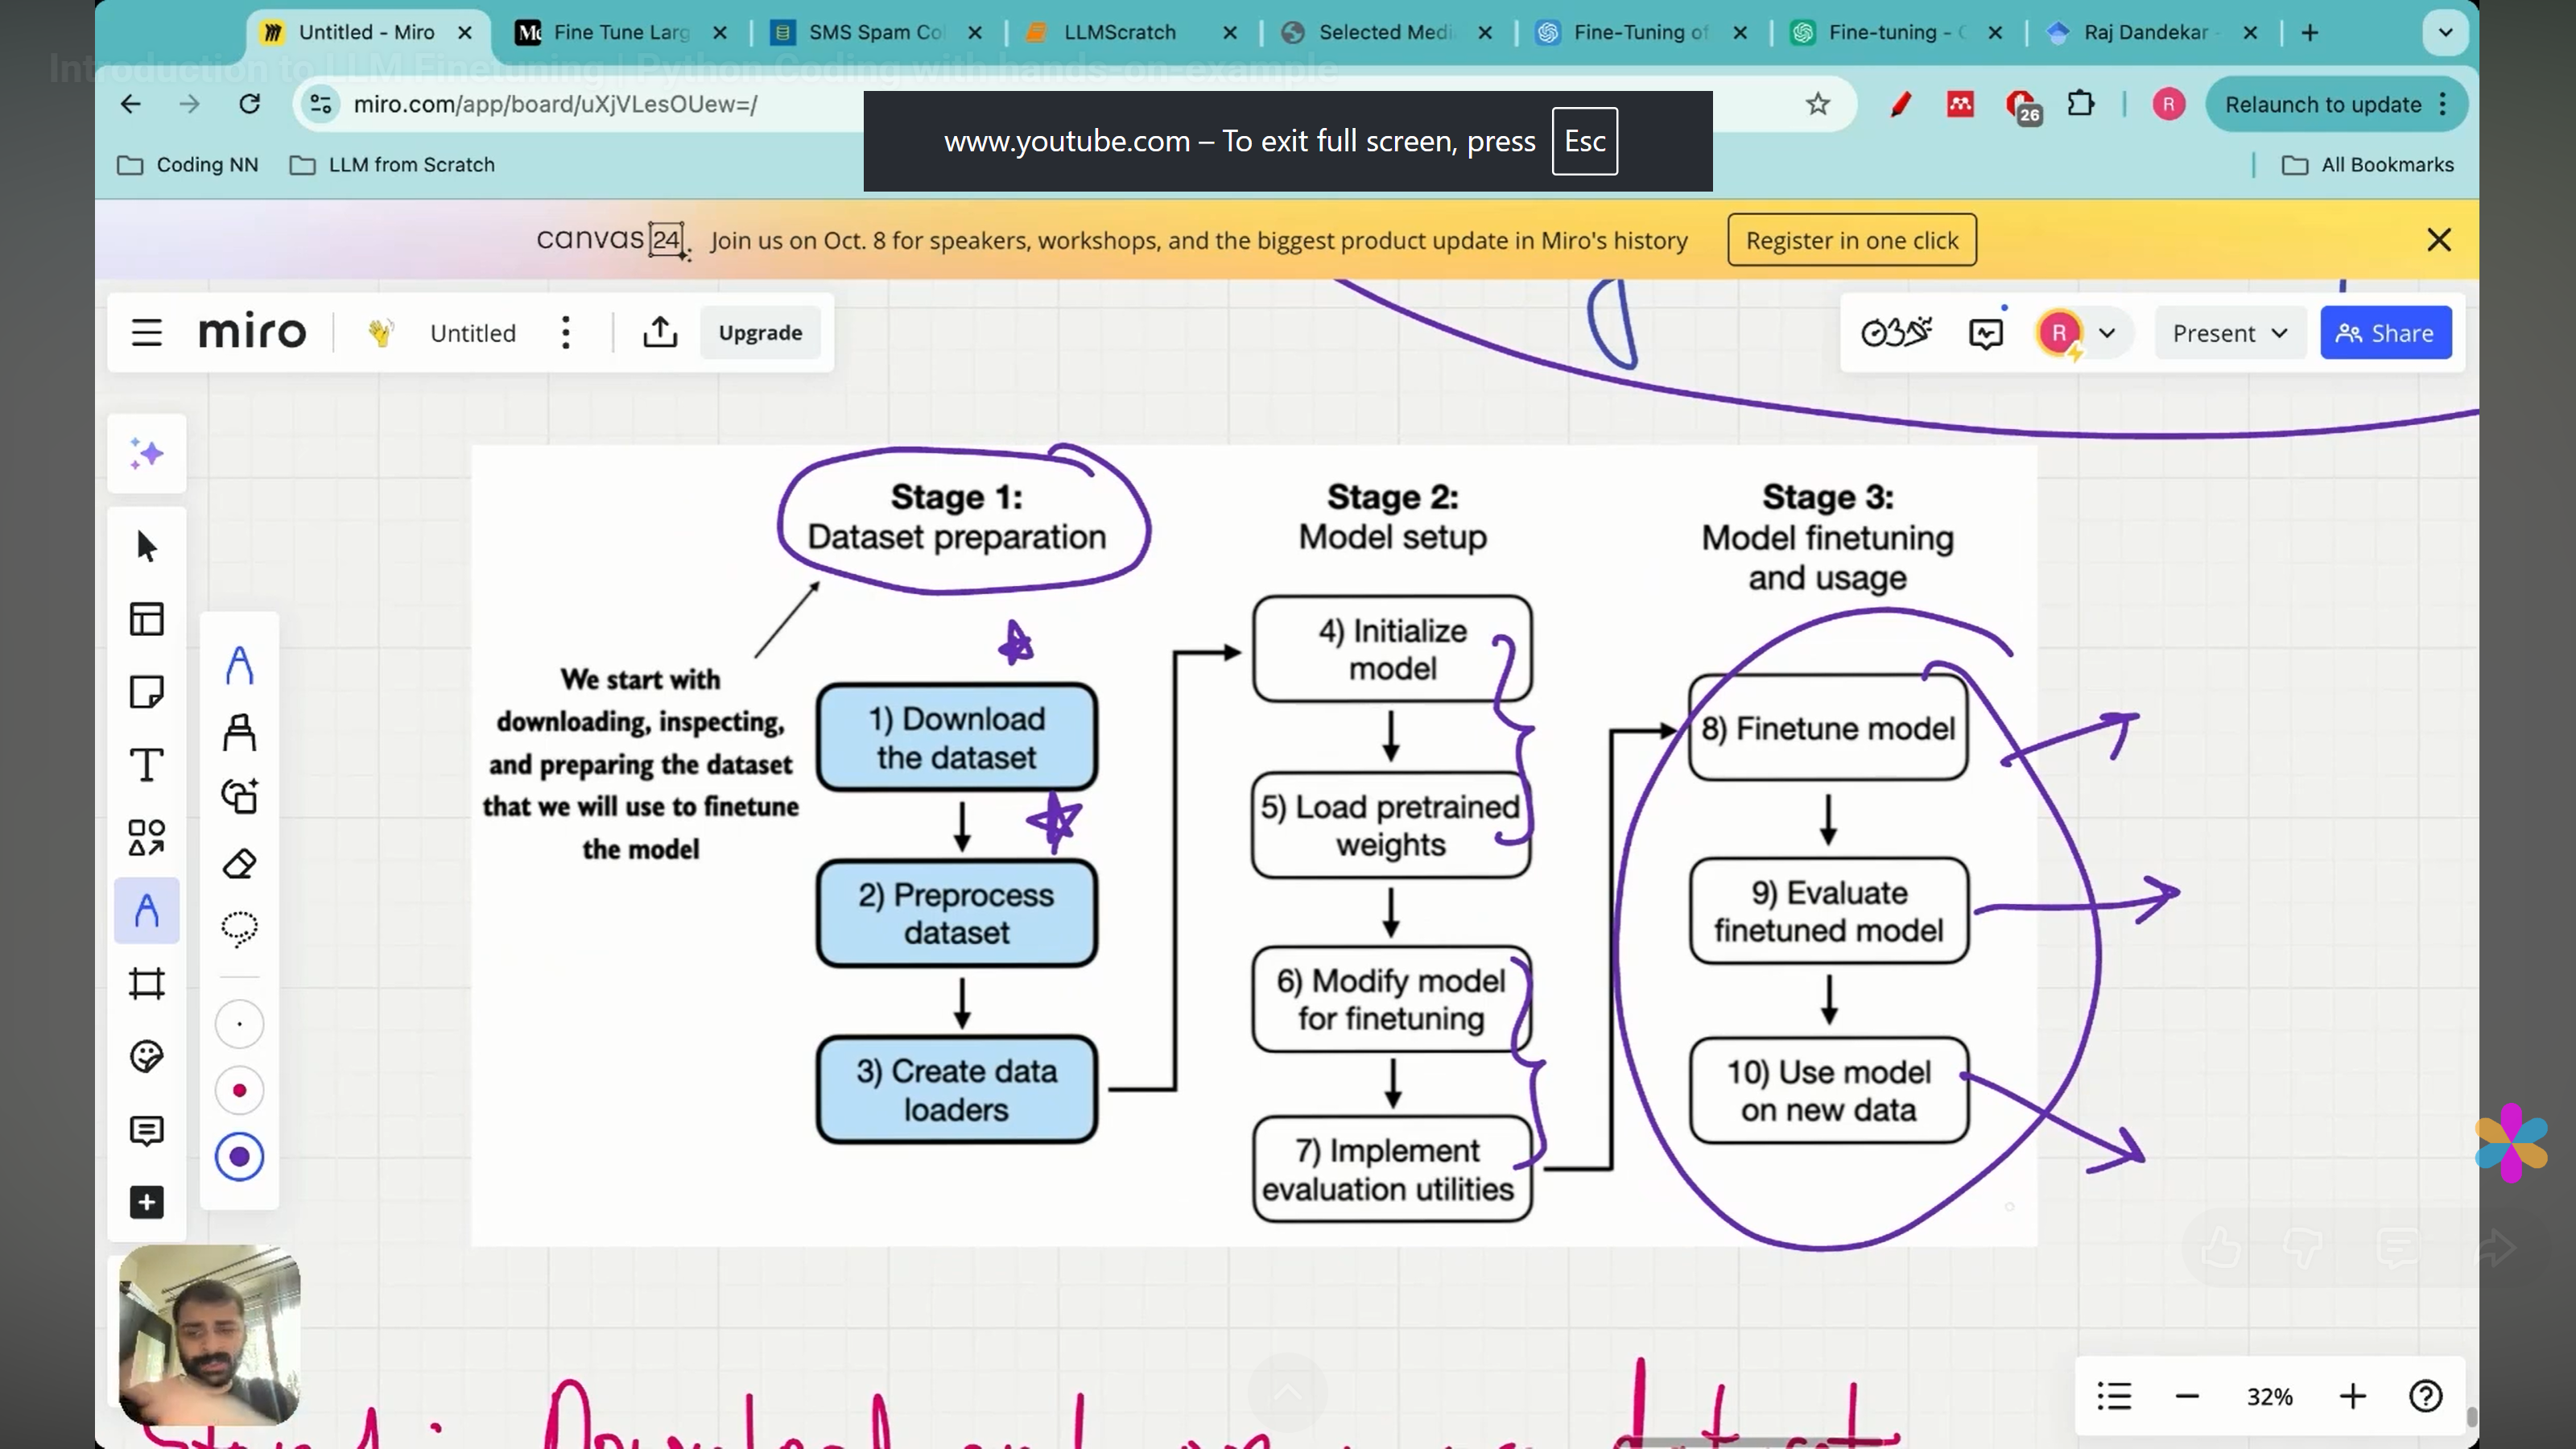

# 1.Download the Dataset

In [ ]:
#Downloading the dataset

import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # Create an unverified SSL context
    ssl_context = ssl._create_unverified_context()

    # Downloading the file
    with urllib.request.urlopen(url, context=ssl_context) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # Unzipping the file
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # Add .tsv file extension
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)


File downloaded and saved as sms_spam_collection/SMSSpamCollection.tsv


In [ ]:
#Load to pandas Dataframe

import pandas as pd
df=pd.read_csv(data_file_path,sep='\t',header=None, names=["Label", "Text"])
df.head(10)

Label                                               Text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...
5  spam  FreeMsg Hey there darling it's been 3 week's n...
6   ham  Even my brother is not like to speak with me. ...
7   ham  As per your request 'Melle Melle (Oru Minnamin...
8  spam  WINNER!! As a valued network customer you have...
9  spam  Had your mobile 11 months or more? U R entitle...

# Count the numbers of Label

In [ ]:
count_label=df["Label"].value_counts()
print(count_label)

Label
ham     4825
spam     747
Name: count, dtype: int64


Here Ham is 4825 and Spam is 747.But we need equal number of both ham and spam data for training model.So lets make ham also 747.

In [ ]:
def create_balanced_dataset(df):


  # Separate classes
  ham_df=df[df["Label"]=="ham"]
  spam_df=df[df["Label"]=="spam"]

  # Truncate ham to 747 rows
  ham_df=ham_df.sample(n=747,random_state=42)

  # Combine back
  balanced_df=pd.concat([ham_df,spam_df])

  # Shuffle rows => vaneko data sab mix garney like ham spam ham spam.if we dont do shuffle then data be like ham ham ham ... and spam spam spam ... so it is bad for training
  balanced_df=balanced_df.sample(frac=1,random_state=42).reset_index(drop=True)

  return balanced_df




In [ ]:
balanced_df=create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

balanced_df.head(20)

Label
spam    747
ham     747
Name: count, dtype: int64


Label                                               Text
0   spam  URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...
1   spam  Panasonic & BluetoothHdset FREE. Nokia FREE. M...
2   spam  Do you want a new Video handset? 750 any time ...
3   spam  Hi if ur lookin 4 saucy daytime fun wiv busty ...
4   spam  09066362231 URGENT! Your mobile No 07xxxxxxxxx...
5    ham  Will do. Was exhausted on train this morning. ...
6    ham    Oh Howda gud gud.. Mathe en samachara chikku:-)
7    ham  Dear Hero,i am leaving to qatar tonite for an ...
8    ham                    Great! How is the office today?
9    ham      Oooh bed ridden ey? What are YOU thinking of?
10  spam  U have a secret admirer who is looking 2 make ...
11   ham                           Sent me ur email id soon
12  spam  Free-message: Jamster!Get the crazy frog sound...
13  spam  PRIVATE! Your 2003 Account Statement for shows...
14   ham  Oic cos me n my sis got no lunch today my dad ...
15   ham                 Hey check it da. I have listed da.
16  spam  URGENT! Your Mobile number has been awarded wi...
17   ham                                             ALRITE
18  spam  Do you want a NEW video phone750 anytime any n...
19   ham  Its on in engalnd! But telly has decided it wo...

Now we can see the equal number of ham and spam.Also the data are shuffled.So we need to convert string labels like ham and spam into numeric '0' and '1'.

In [ ]:
balanced_df["Label"]=balanced_df["Label"].map({"ham":0,"spam":1})

# now splits the data into training data ->70% , validation data ->10% and test data -> 20%.

In [ ]:
def random_splits(df,train_frac,val_frac):
  #calculate splits index
  train_end=int(len(df)*train_frac)
  val_end=train_end+int(len(df)*val_frac)

  #splits the dataframe
  train_df=df[:train_end]
  val_df=df[train_end:val_end]
  test_df=df[val_end:]

  return train_df,val_df,test_df


In [ ]:
train_df,validation_df,test_df=random_splits(balanced_df,0.7,0.1)

In [ ]:
print(len(train_df))
print(len(validation_df))
print(len(test_df))
print(f"total is :{len(train_df)+len(validation_df)+len(test_df)}")

1045
149
300
total is :1494


# Now,we save the dataframe into csv file(comma seperated file) which we can reuse later.

In [ ]:
train_df.to_csv("train.csv",index=None)
validation_df.to_csv("validation.csv",index=None)
test_df.to_csv("test.csv",index=None)

In [ ]:
train_df = pd.read_csv("train.csv")

print(train_df.head(20))

    Label                                               Text
0       1  URGENT, IMPORTANT INFORMATION FOR O2 USER. TOD...
1       1  Panasonic & BluetoothHdset FREE. Nokia FREE. M...
2       1  Do you want a new Video handset? 750 any time ...
3       1  Hi if ur lookin 4 saucy daytime fun wiv busty ...
4       1  09066362231 URGENT! Your mobile No 07xxxxxxxxx...
5       0  Will do. Was exhausted on train this morning. ...
6       0    Oh Howda gud gud.. Mathe en samachara chikku:-)
7       0  Dear Hero,i am leaving to qatar tonite for an ...
8       0                    Great! How is the office today?
9       0      Oooh bed ridden ey? What are YOU thinking of?
10      1  U have a secret admirer who is looking 2 make ...
11      0                           Sent me ur email id soon
12      1  Free-message: Jamster!Get the crazy frog sound...
13      1  PRIVATE! Your 2003 Account Statement for shows...
14      0  Oic cos me n my sis got no lunch today my dad ...
15      0               

# 3.Creating Dataloader

Since, there are differents size of text inside the data like one ham text has length something and other has something, not equal.So we need to make the length of each text data ham and spam are same.

Steps to create a dataloader and making all the text length are same.<br>
step 1: Identify the longest sequence in training dataset.<br>
step 2: Encodes the text message (convert into tokenId).<br>
step 3: Use padding token if the length is less than maximum token.Pading token is 50256 which indicates that end of token i.e there are no text in vocabulary.

In [ ]:
import tiktoken
tokenizer = tiktoken.get_encoding("gpt2")


In [ ]:
import torch
from torch.utils.data import Dataset

class SpamDataset(Dataset):
  def __init__(self,csv_file,tokenizer,max_length=None,pad_token_id=50256):
    self.data = pd.read_csv(csv_file)

    #pre_tokenize text
    self.encoded_texts=[tokenizer.encode(text) for text in self.data["Text"]]   #encoded text aaba form ma hunxa [
                                                                                                              #   [12, 45, 7, 301,102,105],
                                                                                                              #   [9, 33, 78, 441],
                                                                                                              #   [90, 12, 67, 201]
                                                                                                              # ]
    if max_length is None:
      self.max_length=self._longest_encoded_length()

    else:
      self.max_length=max_length


      #truncant sequence if they are longer than max_length
      self.encoded_texts = [ encoded_text[:self.max_length] for encoded_text in self.encoded_texts]

    #Now pad token to less than max_length

    # for i in range(len(self.encoded_texts)):
    #   if len(self.encoded_texts[i]) < max_length:
    #     self.encoded_texts[i] = self.encoded_texts[i] + [pad_token_id] * (max_length - len(self.encoded_texts[i]))


    #Best reccomended code for the operation of list comprehensive (Pad token to less than max_length)
    self.encoded_texts = [encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
                     if len(encoded_text) < self.max_length else encoded_text
                     for encoded_text in self.encoded_texts
                     ]


  def  __getitem__(self,index):
    encoded = self.encoded_texts[index]
    label = self.data.iloc[index]["Label"]

    return (
        torch.tensor(encoded , dtype = torch.long),
        torch.tensor(label , dtype = torch.long)
     )            # => yesto output return garxa   (tensor([12, 45, 7, 301, 102, 105]), tensor(1))




  def __len__(self):
    return len(self.data)




  def _longest_encoded_length(self):
    max_length=0
    for encode_text in self.encoded_texts:
      encoded_length=len(encode_text)
      if encoded_length>max_length:
        max_length=len(encode_text)

    return max_length







In [ ]:
# now calculate the maximum length of the sequence

train_dataset = SpamDataset(csv_file="train.csv",tokenizer=tokenizer,max_length=None)

In [ ]:
print(train_dataset.max_length)

109


Now, we pad the validation data and test data also to match the maximum length of trainind data.This is optional no such rule to match max length for validation and test data.

In [ ]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    tokenizer = tokenizer,
    max_length = train_dataset.max_length

)



#for test data
test_dataset = SpamDataset(
    csv_file="test.csv",
    tokenizer = tokenizer,
    max_length= train_dataset.max_length
)

In [ ]:
#check if correct
print(test_dataset.max_length)

109


Now,create a dataloader to send the data into chunks and send to the model for training using above train,val and test dataset.


Choosing the batch size of 8,each batch will consits of 8 trainig examples of length 120.

---



In [ ]:
from torch.utils.data import DataLoader

num_worker = 0
batch_size = 8

  #batch_size = 8 vaneko “8 ota matra batch huncha” haina

  # Yo vaneko “1 batch bhitra 8 ota rows (samples) huncha” ho

  # Total kati batch huncha vanera chai dataset ko size le decide garcha



torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=num_worker,
    drop_last=True

)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=num_worker,
    drop_last=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=num_worker,
    drop_last=True
)

In [ ]:
print("Train Loader:")

for input_batch,target_batch in train_loader:
  pass      #for now, do nothing, continue

print("Input Batch dimension:",input_batch.shape)
print("Target Batch dimension:",target_batch.shape)



Train Loader:
Input Batch dimension: torch.Size([8, 109])
Target Batch dimension: torch.Size([8])


Mathi ko output yo form ma aauxa =>input batch tensor([
 [ 15496,   995,   318,  ... , 50256, 50256],
 [   464,  3290,   286,  ... , 50256, 50256],
 ...
])   <br>

target batch => tensor([1, 0, 1, 0, 0, 1, 0, 1])



To get an idea of dataset size,lets print the total number of batches in each dataset.

In [ ]:
print(f"Training batches is:{len(train_loader)}")
print(f"Validation batches is:{len(val_loader)}")
print(f"Test batches is:{len(test_loader)}")


Training batches is:130
Validation batches is:18
Test batches is:37


This Conclude the Data preparation.Next, will prepare the model for finetuning.

# Initializing A Model with Pretrained Weights

Now,we will use the pretrained gpt2 model which we made earlier.We finetuned the classification to identify the spam and ham(not spam) message using the pretrained model.

In [6]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 1024, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": True      # Query-key-value bias
}


In [7]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-small (124M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])

print(NEW_CONFIG)


{'vocab_size': 50257, 'context_length': 1024, 'emb_dim': 768, 'n_heads': 12, 'n_layers': 12, 'drop_rate': 0.1, 'qkv_bias': True}


declare the condition for all context_length of model should be greater than the maximum length per sequence of input data.#यदि 1 batch ko shape (8, 1500) भयो भने each 8 row (1500 tokens) > context length(1024) 👉 context length exceed huncha  👉 error aaucha OR data truncate huncha tesailey jahiley maximum length per sequece context length vanda sano hunuparxa.

In [ ]:
assert NEW_CONFIG["context_length"] >= train_dataset.max_length, (
    "Context length must be greater than max length "
    f"(context_length={NEW_CONFIG['context_length']})"
)


-Now, Download and Load the pretrained gpt2 weights which we download earlier.

In [ ]:
import os

os.listdir("/content")


['.config',
 'validation.csv',
 'sms_spam_collection.zip',
 'test.csv',
 'sms_spam_collection',
 'train.csv',
 'sample_data']

In [ ]:
from gpt_download3 import download_and_load_gpt2


In [ ]:
model_size = model_name.split("(")[1].replace(")","")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 148kiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
encoder.json: 100%|██████████| 1.04M/1.04M [00:00<00:00, 2.78MiB/s]
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verificat

we have made the gpt architecture so

In [9]:
model = GPTModel(NEW_CONFIG)
model.eval();


In [ ]:
#we have coded the load_weight_into_gpt method earlier,so use it here
load_weights_into_gpt(model,params)

In [ ]:
#now check the pretrained model loads and works correctly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move model to GPU
model = model.to(device)

torch.manual_seed(123)

token_ids = Generate_text(
    model=model,
    idx=text_to_token_ids("Every efforts moves you", tokenizer).to(device),
    max_new_tokens=20,
    context_size=NEW_CONFIG["context_length"],
    top_k=40,
    temperature=0.8
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every efforts moves you as far as the eye can see. (That's because you're not going to be able to


Now, our pretrained gpt2 model is ready.So we need to finetune our message classifier model

Before finetuning the model,lets see our pretrained model can classify or not the spam classifier.

In [ ]:
text_2 = ("Is this following 'Spam'? Answer with 'yes' or 'no':"
          "yor are winner! yo have been specially"
          "Selected to receive $1000 cash or a $2000 award. "
          )


token_ids = Generate_text(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer).to(device),
    max_new_tokens=40,
    context_size=NEW_CONFIG["context_length"],
    top_k=40,
    temperature=0.8
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Is this following 'Spam'? Answer with 'yes' or 'no':yor are winner! yo have been speciallySelected to receive $1000 cash or a $2000 award. ????

Yor you are a winner of this award. Your email address will be added to the list. You may change your mind at any time. You cannot change your mind about any of


As we see from above output that our pretrained model cannot predict the msg spam or not.So we need to finetune our model and we train in our spam and ham data.

For this, we change the output head(output projection) of our gpt2 architecture which gives the output to 50256 vacab size.But, to find a message spam and ham,only two output tensor is needed.Thats why, we gonna change output head is equal to the number of class(spam and ham) i.e 2 later in code.

It is also known as adding of classification head instead of our model architecture output head.To understand more,lets see the figure below:

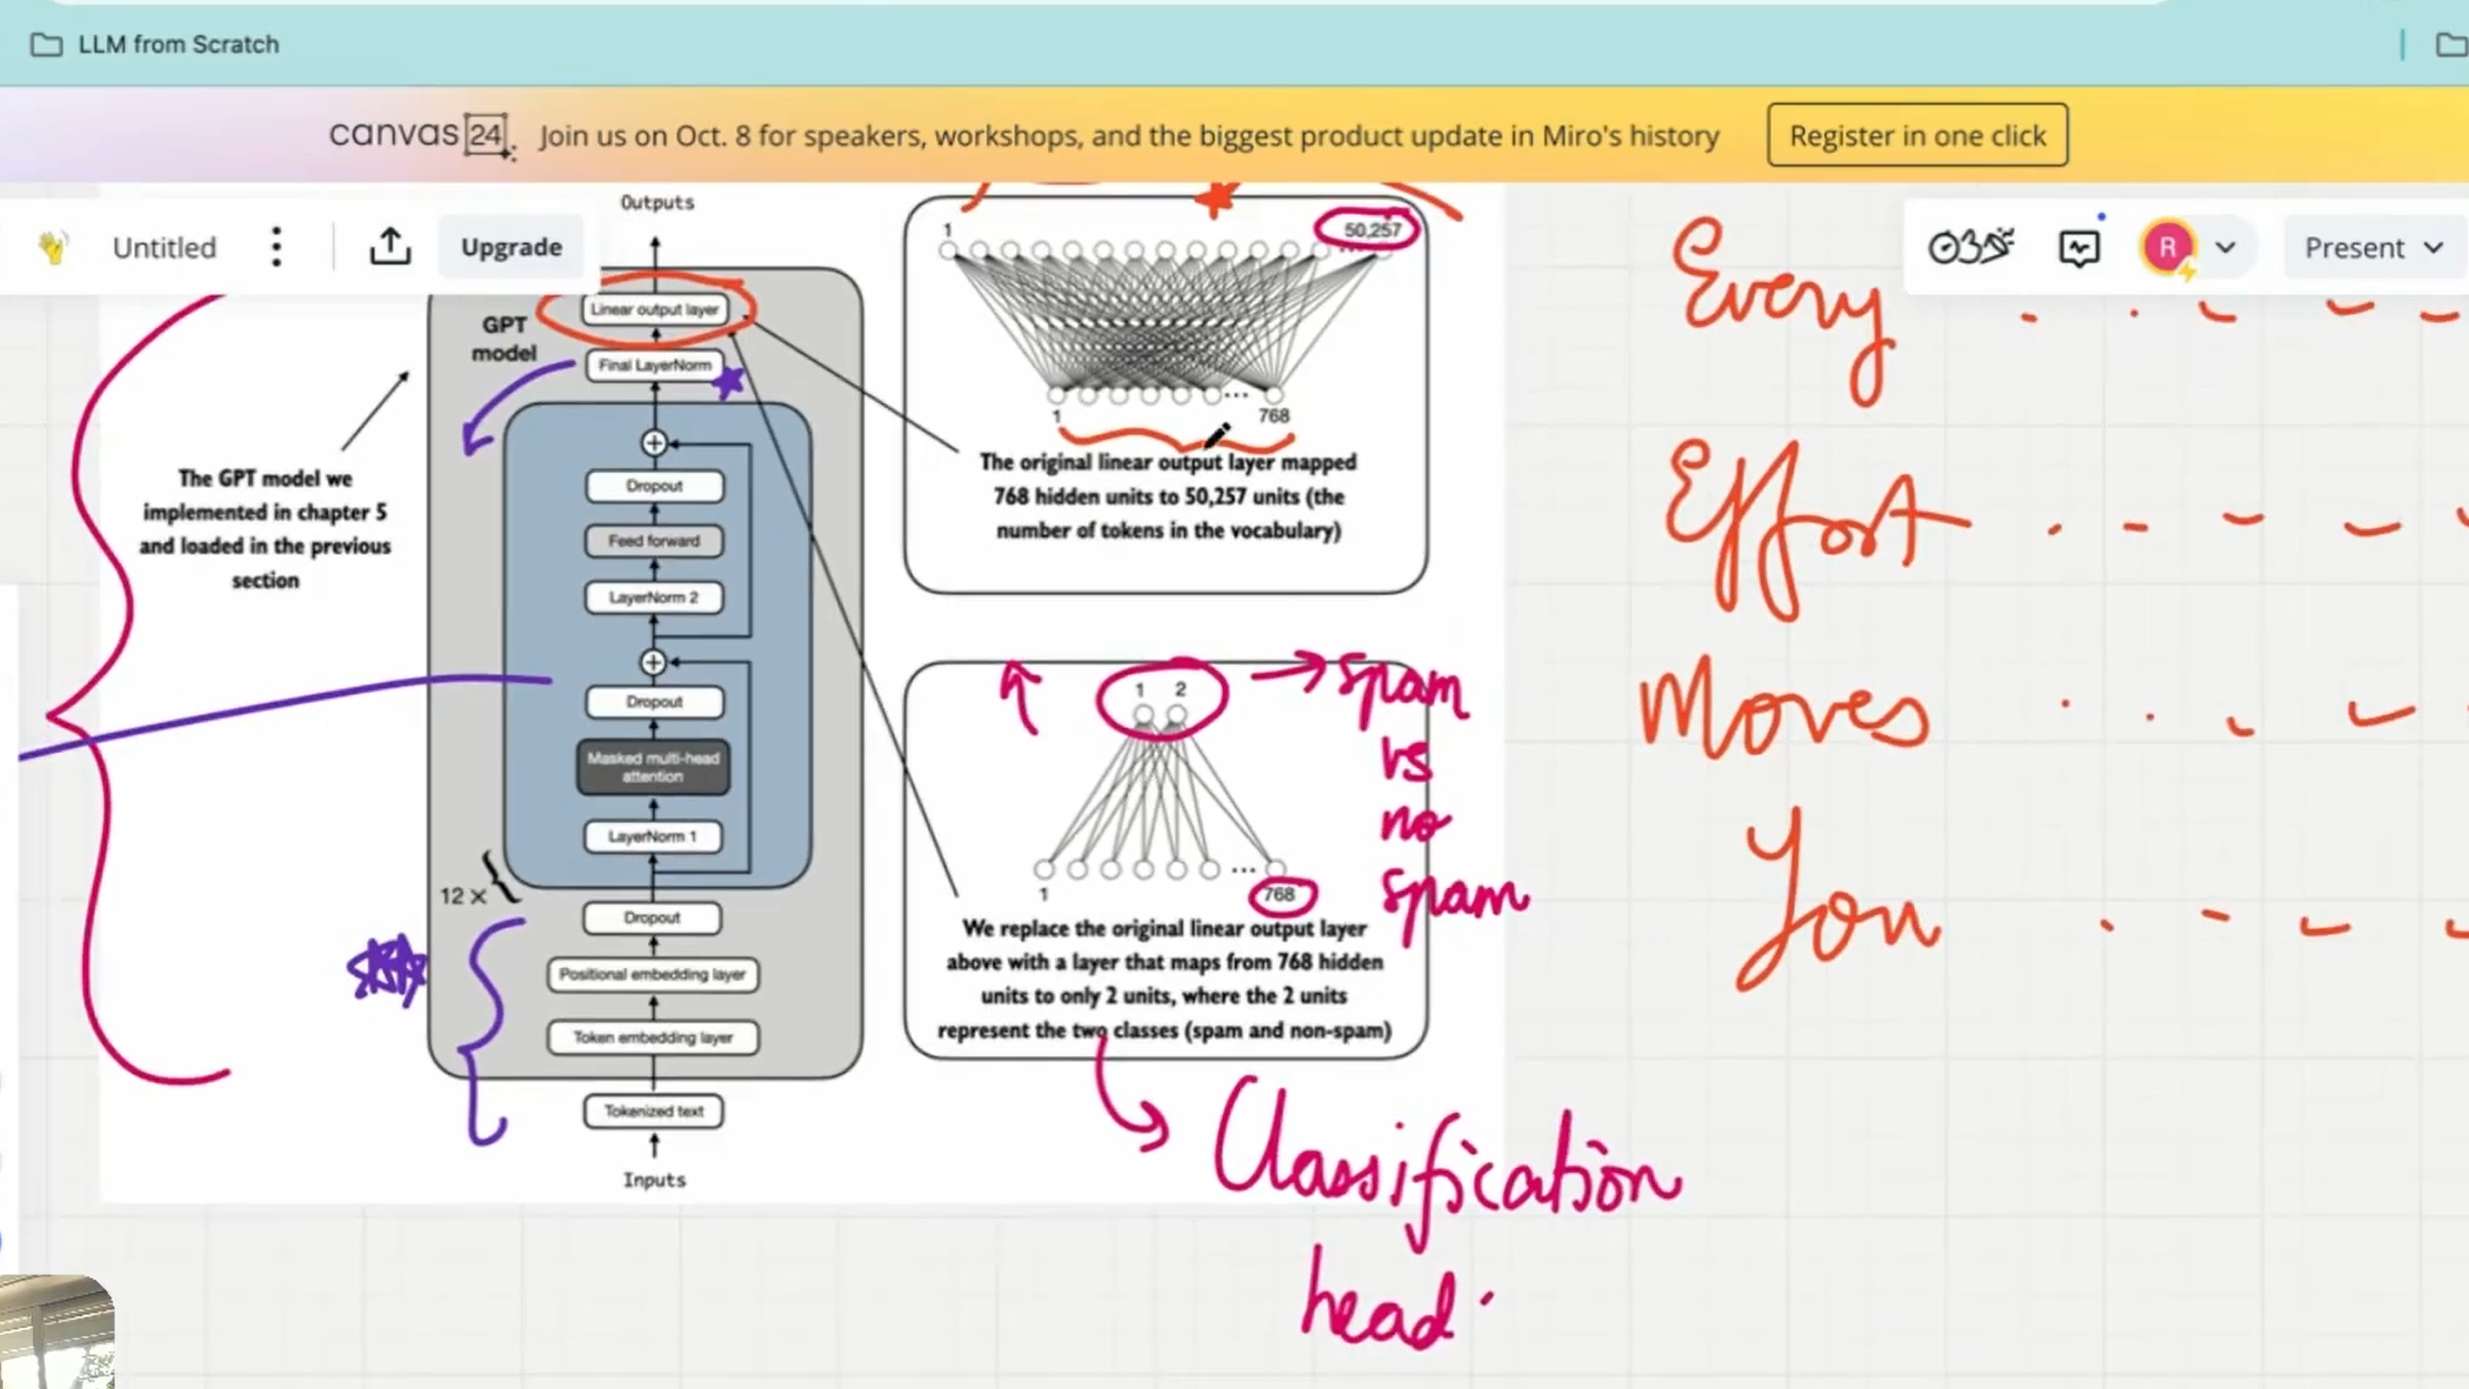

Here,we replace the original linear output layer above with a layer that maps from 768 hidden units to only 2 units,where the 2 units represent the two classes (spam and non-spam)

We let the other layers as it is,since they already understand the basics like semantics of text from the pretraining.But,we  add classification head for classify the ham and spam and only train the one transformer block among the 12.Only one transformer block is retrained because to understand more about our data.

Now, lets see the model architecture

In [ ]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

To get the model ready for classification-finetuning, we first freeze the model,meaning we make all layer non-trainable.

In [ ]:
for param in model.parameters():
  param.requires_grad = False

Then we replace the output layer (model.out_head),which originally maps the layer inputs to 50257 dimension to num_classes.Lets position if want to classify 3 things then num_class is 3.

In [10]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=NEW_CONFIG["emb_dim"],out_features=num_classes)

lets see output head after change

In [11]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

Here,from above model illustration all the parameter required_grad is False because we freeze the model i.e required_grad is Falsea(bias=False).But,output head bias is True i.e ready for the training.

Similarly we change the transformer last block and ready for training.And, also the Final Layer Normalization layer require_grad is true.

In [12]:
for param in model.trf_blocks[-1].parameters():
  param.requires_grad = True


for param in model.final_norm.parameters():
  param.requires_grad = True

Now,lets check it out a sample input whether the model output is two or not.The format we need the ouput head dimension is two.so

In [18]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0) #add batch
print(inputs)
print(inputs.shape)

tensor([[5211,  345,  423,  640]])
torch.Size([1, 4])


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# move model to device
model = model.to(device)

# move input tensor to same device
inputs = inputs.to(device)

with torch.no_grad():
  outputs = model(inputs)
  print(outputs)
  print(outputs.shape)  #batch,num_token,output

tensor([[[-0.0459, -0.3850],
         [-0.4413, -0.2044],
         [ 0.6888, -0.7929],
         [ 0.4334,  0.4357]]], device='cuda:0')
torch.Size([1, 4, 2])


Now, we just need the last row which have 2 tensor.we dont need all the rows since we only focus on spam or not only two.

In [ ]:
#extract the last tensor
outputs = outputs[:,-1,:] # since the dimension is ([1, 4, 2]) and after slicing the last sequence the dimension of outputs will be [1,2] because -1 removes the dimension if you want to take put -1:(but we remove dimension)
print(outputs)
print(outputs.shape)

tensor([[-3.5983,  3.9902]], device='cuda:0')
torch.Size([1, 2])


here, we need the output value which is highest between two tensor.So, we use argmax() function to extract the highest value.Earlier in LLM generative text model we use softmax and only we will use argmax func.But, here in our spam classifier we dont need to use softmax before since we just need the highest value between two value and the result will be same if we use the softmax before and then argmax function.

Lets see the example with Softmax and without Softmax

In [ ]:
probas = torch.softmax(outputs,dim=-1)  #dim=-1 kina vaney last dimension ma softmax use garnuparxa like hamro tensor ko dimension yesto xa (1,2)
label = torch.argmax(probas) # torch.argmax ley maximum value ko index dinxa not max value
print("Class Label:",label.item()) #int ma convert garxa tensor lai because torch.argmax ley direct int value dinna yesley tensor value dinxa like tensor(1)


Class Label: 1


Here, the code returns the 1 "means" Spam.Using softmax function is optional the largest output directly corresponding the highest probability scores.

In [ ]:
#without softmax
label = torch.argmax(outputs)
print("class label:",label.item())

class label: 1


Now,lets calculate the Classification Accuracy

In [ ]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
  num_examples,correct_predictions = 0,0
  if num_batches is None:
    num_batches = len(data_loader)

  else:
    num_batches = min(num_batches,len(data_loader))

  for i,(input_batch,target_batch) in enumerate(data_loader):
    if i < num_batches:
      input_batch = input_batch.to(device)
      target_batch = target_batch.to(device)

      with torch.no_grad():
        logits = model(input_batch)[:,-1,:] #model ma input_batch pathauney every num_batch ma ani last sequnce ko tensor nikalney
        predicted_labels = torch.argmax(logits, dim=-1)
        num_examples += predicted_labels.shape[0]
        correct_predictions += (predicted_labels == target_batch).sum().item()

    else:
      break
  return correct_predictions / num_examples





lets use the function to determine the classification accuracy across various dataset estimated from 10 batches for efficiency

In [ ]:
model.to(device)

train_accuracy = calc_accuracy_loader(train_loader,model,device,num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader,model,device,num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader,model,device,num_batches=10)

print(f"Train Accuracy:{100*train_accuracy:.2f}%")
print(f"Validation Accuracy:{100*val_accuracy:.2f}%")
print(f"Test Accuracy:{100*test_accuracy:.2f}%")

Train Accuracy:52.50%
Validation Accuracy:46.25%
Test Accuracy:53.75%


Here the above accuracy means that our model predicts like 50% true and 50% false at a time.So it indicates very bad prediction.And we havenot train our data yet.So we are going to train our custom data now for the better prediction.

now,calculate the loss batch using the loss function => Cross Entropy Loss.<br>
-CE Loss = −log(pcorrect class)

In [ ]:
def calc_loss_batch(input_batch,target_batch,model,device):
  input_batch,target_batch = input_batch.to(device),target_batch.to(device)
  logits = model(input_batch)[:,-1,:] #last tensor
  loss = torch.nn.functional.cross_entropy(logits,target_batch)
  return loss

now we define the calc_loss_loader func to calculate the loss of single batch loader

In [ ]:
def calc_loss_loader(data_loader,model,device,num_batches=None):
  total_loss = 0
  if len(data_loader)==0:
    return float("nan")

  elif num_batches is None:
    num_batches = len(data_loader)

  else:
    num_batches = min(num_batches,len(data_loader))

  for i,(input_batch,target_batch) in enumerate(data_loader):
    if i<num_batches:
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      total_loss += loss.item()

    else:
      break
  return total_loss/num_batches



In [ ]:
#lets check loss before training and backpropagation
with torch.no_grad():
  train_loss = calc_loss_loader(train_loader,model,device,num_batches=5)
  val_loss = calc_loss_loader(val_loader,model,device,num_batches=5)
  test_loss = calc_loss_loader(test_loader,model,device,num_batches=5)

print(f"Train Loss:{train_loss:.3f}")
print(f"Validation Loss:{val_loss:.3f}")
print(f"Test Loss:{test_loss:.3f}")

Train Loss:2.288
Validation Loss:2.058
Test Loss:2.786


# Now,We are ready for Finetuning our custom dataset spam or not.So, we gonna train the model and backpropagate in our data.

After finetunig our model accurancy goes high and predict good results.

Steps for training , backpropagate and calculate the loss.<br>

step1 : set model to training mode<br>
step2 : Reset loss gradient from previous batch iteration <br>
step3 : Calculate loss gradient<br>
step4 : Update model weight using loss gradient <br>
step5 : New track example instead of tokens<br>
step6 : Optional evaluation steps <br>
step7 : Calculate accuracy after each epochs


In [ ]:
#same as we did in earlier in gpt2 training.
def train_classifier(model,device,train_loader,val_loader,num_epochs,optimizer,eval_freq,eval_iter):
  train_losses,val_losses,train_accs,val_accs = [],[],[],[]
  example_seen,global_step = 0,0

  #main training loop
  for epoch in range(num_epochs):
    model.train() #set model to training mode

    for input_batch,target_batch in train_loader:
      optimizer.zero_grad()  #reset the loss gradient
      loss = calc_loss_batch(input_batch,target_batch,model,device)
      loss.backward() #calculate the loss gradient
      optimizer.step() #update model weights
      example_seen += input_batch.shape[0]  #input_batch.shape[0] = 8
      global_step += 1

      #optinal evaluation step
      if global_step % eval_freq == 0:
        train_loss,val_loss = evaluate_model(train_loader,val_loader,
                                             model,device,eval_iter)
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"Ep {epoch+1} (Step {global_step:06d}) :"
        f" Train Loss {train_loss:.3f},Validation Loss {val_loss:.3f}")

      #Calculate accuracy after each epochs
    train_accuracy = calc_accuracy_loader(train_loader,model,device)
    val_accuracy = calc_accuracy_loader(val_loader,model,device)
    print(f"Training Accuracy {train_accuracy * 100:.2f}% | ",end="")
    print(f"Validation Accuracy {val_accuracy * 100:.2f}%")
    train_accs.append(train_accuracy)
    val_accs.append(val_accuracy)

  return train_losses,val_losses,train_accs,val_accs,example_seen



In [ ]:
def evaluate_model(train_loader,val_loader,model,device,eval_iter):
  model.eval()
  with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device,num_batches=eval_iter)
    val_loss = calc_loss_loader(val_loader,model,device,num_batches=eval_iter)

  model.train()
  return train_loss,val_loss

Now, We set the optimizer and number of epochs then we are ready for the training using the train_classifier function.

In [ ]:
import time
start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5,weight_decay=0.1)
num_epochs = 5
train_losses,val_losses,train_accs,val_accs,example_seen = train_classifier(model,device,train_loader,val_loader,num_epochs,optimizer,eval_freq=50,eval_iter=5)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training Completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000050) : Train Loss 0.385,Validation Loss 0.627
Ep 1 (Step 000100) : Train Loss 0.181,Validation Loss 0.515
Training Accuracy 85.87% | Validation Accuracy 81.94%
Ep 2 (Step 000150) : Train Loss 0.307,Validation Loss 0.371
Ep 2 (Step 000200) : Train Loss 0.486,Validation Loss 0.545
Ep 2 (Step 000250) : Train Loss 0.385,Validation Loss 0.606
Training Accuracy 85.67% | Validation Accuracy 84.03%
Ep 3 (Step 000300) : Train Loss 0.263,Validation Loss 0.541
Ep 3 (Step 000350) : Train Loss 0.142,Validation Loss 0.201
Training Accuracy 88.27% | Validation Accuracy 83.33%
Ep 4 (Step 000400) : Train Loss 0.376,Validation Loss 0.232
Ep 4 (Step 000450) : Train Loss 0.186,Validation Loss 0.308
Ep 4 (Step 000500) : Train Loss 0.277,Validation Loss 0.169
Training Accuracy 91.73% | Validation Accuracy 92.36%
Ep 5 (Step 000550) : Train Loss 0.122,Validation Loss 0.214
Ep 5 (Step 000600) : Train Loss 0.258,Validation Loss 0.354
Ep 5 (Step 000650) : Train Loss 0.228,Validation Loss 0.625
Trai

In [ ]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, example_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # Create a second x-axis for examples seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(example_seen, train_values, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Example seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

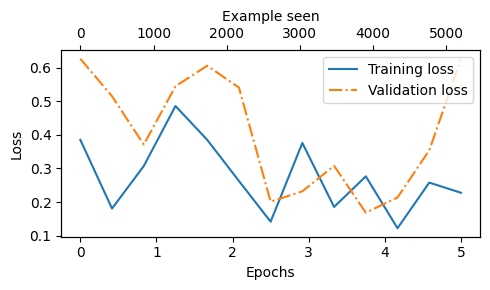

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

As we can see based on the sharp downward slope, the model is learning well from the training data, and there is little to no indication of overfitting; that is, there is no noticeable gap between the training and validation set losses).

Now Accuracies

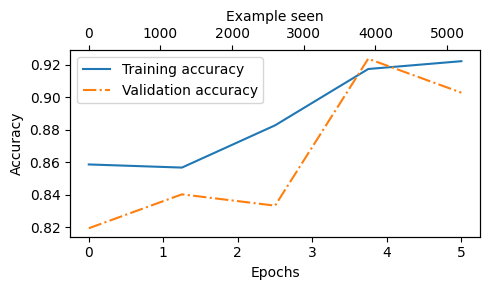

In [ ]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, example_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

Based on the accuracy plot in figure 6.17, the model achieves a relatively high training and validation accuracy after epochs 4 and 5.

However, it's important to note that we previously set eval_iter=5 means epochs = 5 when using the train_classifier_simple function, which means our estimations of training and validation performance were based on only 5 batches for efficiency during training.

Now, we will calculate the performance metrics for the training, validation, and test sets across the entire dataset by running the following code, this time without defining the eval_iter value:

In [ ]:
#model train vayo aaba actual accuries after the model train
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 90.96%
Validation accuracy: 88.19%
Test accuracy: 91.55%


Now Test our spam classifier model in unseen data

In [ ]:
#Inference Testing
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # Prepare inputs to the model
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[0]
    # Note: In the book, this was originally written as pos_emb.weight.shape[1] by mistake
    # It didn't break the code but would have caused unnecessary truncation (to 768 instead of 1024)

    # Truncate sequences if they too long
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # Pad sequences to the longest sequence
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # add batch dimension

    # Model inference
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # Logits of the last output token
    predicted_label = torch.argmax(logits, dim=-1).item()

    # Return the classified result
    return "spam" if predicted_label == 1 else "not spam"

Let's try this classify_review function on an example text:

In [ ]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [ ]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


In [ ]:
text_3 =("Congratulation you have received $1000.Claim it.")
print(classify_review(
    text_3, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


Now save model incase we want to reuse without training it

In [ ]:
torch.save(model.state_dict(), "spam_classifier.pth")

Once saved, the model can be loaded as follows:

In [ ]:
model_state_dict = torch.load("spam_classifier.pth")
model.load_state_dict(model_state_dict)

Collab ma vayera after the runtime disconnected we cannot use the same model which i trained earlier.So if i want to use the spam classifier model i have to train it again.And must do after training just save this model in google collab.

Classifier finetuning has been done now.We have build a spam message classifier model.So lets build the instruction finetuning in next lecture i.e Chatbot.